# Hidden Markov Model (HMM) for Constraint Predictions on Regeneron Genetics Center Million Exome (RGC-ME) Dataset

This notebook trains a Hidden Markov Model (HMM) to generate constraint predictions on the RGC-ME dataset. The predictions are made based on variant observations in protein-coding regions with high exome coverage. The methods described in this notebook align with those detailed in the Methods section of the paper.

## Setup
This section installs the necessary Python packages and imports the required libraries for data processing, statistical analysis, and Hidden Markov Model (HMM) training.

In [ ]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install hmmlearn
!pip install statsmodels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
import gzip
import os
from tqdm import tqdm, trange
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import fisher_exact
import warnings
import joblib

# Suppress all warnings
warnings.filterwarnings("ignore")

## Specify Project Directories and File Paths
Define the directories where the data is stored and specify the file paths for gene annotation, variant frequencies, and coverage data.

In [2]:
# Specify project directories in Sherlock
data_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/data/'
results_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/osthoag/wgs-constraint-llm/results/'

# Specify the file paths
gene_annotation_file_path = data_path + 'gencode.v44.basic.annotation.gtf.gz'
variants_file_path = data_path + 'rgc_me_variant_frequencies_20231004.vcf.gz'
coverage_file_path = data_path + 'gnomad.exomes.v4.0.coverage.summary.tsv.bgz'

## Define Helper Methods
This section defines various helper functions that are used throughout the notebook. These include functions for sequence extraction, HMM fitting and prediction, statistical analysis, and plotting.

In [3]:
# Function to extract the observation sequence for the HMM
def get_sequence(chromnum):
    # Filter gene df for given chromosome
    chr_gene_df = gene_df[gene_df['chr'] == 'chr' + str(chromnum)]
    
    # Filter variant df for given chromosome
    chr_variants_df = variants_df[variants_df['chr'] == chromnum]
    
    # Filter coverage data for chromosome 2 based on the coverage threshold
    chr_coverage_df = coverage_df[(coverage_df['chr'] == 'chr' + str(chromnum))]
    
    # Determine the length of the entire sequence based on gene, coverage, and variant data
    sequence_length = max(chr_gene_df['end'].max(), chr_coverage_df['pos'].max(), chr_variants_df['pos'].max())

    # Initialize a boolean mask for protein-coding regions
    protein_coding_mask = np.zeros(sequence_length + 1, dtype=bool)

    # Mark positions that are within protein-coding regions
    for start, end in zip(chr_gene_df['start'].to_numpy(), chr_gene_df['end'].to_numpy()):
        protein_coding_mask[start:end+1] = 1

    # Initialize a boolean mask for regions with sufficient exome coverage
    coverage_mask = np.zeros(sequence_length + 1, dtype=bool)

    # Mark positions with coverage greater than 80%
    coverage_mask[chr_coverage_df['pos'].to_numpy()] = 1

    # Initialize the sequence array (observations) to zeros
    sequence = np.zeros(sequence_length + 1)

    # Mark positions where variants are observed
    sequence[chr_variants_df['pos'].to_numpy()] = 1

    # Filter the sequence for protein-coding regions with sufficient coverage
    observations = np.array(sequence[protein_coding_mask & coverage_mask])
    
    # Identify the positions that correspond to these observations
    positions = np.where(protein_coding_mask & coverage_mask)[0]
    
    return observations, positions

# Function to fit an HMM to the observations
def fit_HMM(observations, order=2):
    # Prepare the observations for HMM fitting by creating higher-order observations
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Instantiate and fit a first-order HMM
    model = hmm.MultinomialHMM(n_components=2, random_state=10)
    model.fit(X_counts)

    return model

# Function to predict probabilities using a fitted HMM
def get_HMM_predictions(observations, model, order=2):
    # Create higher-order observations (context of order-1)
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts for the HMM
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Predict probabilities for each position in the sequence
    probabilities = model.predict_proba(X_counts)

    return probabilities

# Function to perform Ordinary Least Squares (OLS) regression on prediction data
def ols_regression(predictions_df):
    # Add a constant term to the predictor variable
    X = sm.add_constant(predictions_df['prob_0'])

    # Fit the OLS model and print the summary
    model4 = sm.OLS(predictions_df['observation'],X).fit()

    model4.summary().tables[1].pvalues_precision = 100  # Adjust the number of significant digits

    # Print the regression summary
    print(model4.summary())

    # Extract the F-statistic and associated p-value
    f_statistic = model4.fvalue
    p_value_f_statistic = model4.f_pvalue
    
    return f_statistic, p_value_f_statistic

# Function to plot histograms of observed variants and HMM predictions
def plot_hist_from_predictions(predictions_df):
    # Create a figure with two subplots in one row and two columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the first histogram in the first subplot
    axs[0].hist(predictions_df['observation'], edgecolor="blue")
    axs[0].set_title('Histogram of Observations')
    axs[0].set_xlabel('Has a variant')
    axs[0].set_ylabel('Frequency')

    # Plot the second histogram in the second subplot
    axs[1].hist(predictions_df['prob_0'], edgecolor="blue")
    axs[1].set_title('Histogram of Predictions')
    axs[1].set_xlabel('Probability of 0')
    axs[1].set_ylabel('Frequency')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    plt.show()
    
# Function to plot observed mutations for a subsequence
def plot_subsequence_observations(observations, start_idx, end_idx, name='Target Region'): 
    plt.bar(range(start_idx, end_idx), observations[start_idx:end_idx], color='black', width=1.0)#, label='Original Sequence')
    plt.title("Observed mutations for part of " + name)
    plt.xlabel('Position on Chromosome 2')
    plt.yticks([0,1]) 
    plt.ylabel('Observation')
#     plt.legend()
    plt.margins(x=0)
    plt.tight_layout(rect=[0, 0, 2, 0.5])
    plt.show()
    
# Function to plot HMM predictions for a subsequence
def plot_subsequence_predictions(predictions, start_idx, end_idx, name='Target Region'):    
    plt.bar(range(start_idx, end_idx), predictions[start_idx:end_idx, 0], color='#8C1515', width=1.0, label='Probability of 0')
#     plt.bar(range(start_idx, end_idx), predictions[start_idx:end_idx, 1], bottom=predictions[start_idx:end_idx, 0], color='#D2C295', label='Probability of 1')
    plt.title("HMM Predictions for part of " + name)
    plt.xlabel('Position on Chromosome 2')
    plt.ylabel('Probability of 0')
#     plt.legend()
    plt.margins(x=0)
    plt.tight_layout(rect=[0, 0, 2, 0.5])
    plt.show()
    
# Function to plot both observed mutations and HMM predictions for a subsequence
def plot_subsequence(observations, predictions, start_idx, end_idx, gene_name='Target Region', save_name=None):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True)
    plt.suptitle("Observed Mutations vs HMM Predictions for " + gene_name, y=0.9)

    # Plot the original sequence
    axes[0].bar(range(start_idx, end_idx), observations[start_idx:end_idx], width=1.0, color='black', label='Original Sequence')
    axes[0].set_ylabel('Observation')
#     axes[0].legend()
    axes[0].margins(x=0)
    
    # Plot the predicted probabilities as stacked barplots
    axes[1].bar(range(start_idx, end_idx), predictions[start_idx:end_idx, 0], width=1.0, color='#8C1515')
#     axes[1].bar(range(start_idx, end_idx), predictions[start_idx:end_idx, 1], bottom=predictions[start_idx:end_idx, 0], color='#D2C295', label='Probability of 1')
    axes[1].set_xlabel('Position')
    axes[1].set_ylabel('Probability of 0')
#     axes[1].legend()
    axes[1].margins(x=0)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if save_name is not None:
        plt.savefig(results_path + save_name)
        
    plt.show()

## Load Coverage Data

The following code block reads coverage data from a gzipped file, processes it to split the locus information into chromosome and position, and prepares the data for further analysis.

In [4]:
# Load the coverage data from a gzipped file
with gzip.open(coverage_file_path, 'rt') as coverage_file:
    # Read the file into a pandas DataFrame
    coverage_df = pd.read_csv(coverage_file, sep='\t',
                             usecols=['locus', 'over_10', 'over_20'])

# Split the 'locus' column into 'chr' and 'pos'
coverage_df[['chr', 'pos']] = coverage_df['locus'].str.split(':', expand=True)
coverage_df['pos'] = coverage_df['pos'].astype(int)

# Drop the original 'locus' column as it's no longer needed
coverage_df = coverage_df.drop('locus', axis=1)

# Display the processed coverage DataFrame
coverage_df

,over_10,over_20,chr,pos
0,0.00000,0.00000,chr1,11819
1,0.00000,0.00000,chr1,11820
2,0.00000,0.00000,chr1,11821
3,0.00000,0.00000,chr1,11822
4,0.00000,0.00000,chr1,11823
...,...,...,...,...
170202922,0.29592,0.23756,chrM,16069
170202923,0.29582,0.23788,chrM,16070
170202924,0.29689,0.23808,chrM,16071
170202925,0.29674,0.23815,chrM,16072


## Load Gene Annotation Data

The following block reads gene annotation data from a GTF file, extracts relevant fields such as gene_id, gene_name, and transcript_id, and filters the data to include only protein-coding regions (CDS).

In [5]:
# Read the GTF file into a pandas DataFrame
gene_df = pd.read_csv(gene_annotation_file_path, sep='\t', comment='#', header=None, 
                      names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'], 
                      dtype={'start': int, 'end': int})

# Extract 'gene_id' from attributes
gene_df['gene_id'] = gene_df['attribute'].str.extract(r'gene_id "(.*?)"')

# Extract 'gene_type' from attributes
gene_df['gene_type'] = gene_df['attribute'].str.extract(r'gene_type "(.*?)"')

# Extract 'gene_name' from attributes
gene_df['gene_name'] = gene_df['attribute'].str.extract(r'gene_name "(.*?)"')

# Extract 'transcript_id' from attributes
gene_df['transcript_id'] = gene_df['attribute'].str.extract(r'transcript_id "(.*?)"')

# Split 'transcript_id' into 'transcript' and 'transcript_num'
gene_df[['transcript', 'transcript_num']] = gene_df['transcript_id'].str.split('.', expand=True)

# Extract 'transcript_name' from attributes
gene_df['transcript_name'] = gene_df['attribute'].str.extract(r'transcript_name "(.*?)"')

# Drop the original 'attribute' column as it is no longer needed
gene_df = gene_df.drop('attribute', axis=1)

# Filter the DataFrame to include only protein-coding regions (CDS)
gene_df = gene_df[(gene_df['gene_type'] == 'protein_coding') & (gene_df['feature'] == 'CDS')]

# Display the processed gene DataFrame
gene_df

,chr,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,transcript_id,transcript,transcript_num,transcript_name
60,chr1,HAVANA,CDS,65565,65573,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201
63,chr1,HAVANA,CDS,69037,70005,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201
236,chr1,HAVANA,CDS,450743,451678,.,-,0,ENSG00000284733.2,protein_coding,OR4F29,ENST00000426406.4,ENST00000426406,4,OR4F29-201
304,chr1,HAVANA,CDS,685719,686654,.,-,0,ENSG00000284662.2,protein_coding,OR4F16,ENST00000332831.5,ENST00000332831,5,OR4F16-201
524,chr1,HAVANA,CDS,924432,924948,.,+,0,ENSG00000187634.13,protein_coding,SAMD11,ENST00000616016.5,ENST00000616016,5,SAMD11-209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998488,chrM,ENSEMBL,CDS,10470,10763,.,+,0,ENSG00000212907.2,protein_coding,MT-ND4L,ENST00000361335.1,ENST00000361335,1,MT-ND4L-201
1998495,chrM,ENSEMBL,CDS,10760,12137,.,+,0,ENSG00000198886.2,protein_coding,MT-ND4,ENST00000361381.2,ENST00000361381,2,MT-ND4-201
1998509,chrM,ENSEMBL,CDS,12337,14145,.,+,0,ENSG00000198786.2,protein_coding,MT-ND5,ENST00000361567.2,ENST00000361567,2,MT-ND5-201
1998515,chrM,ENSEMBL,CDS,14149,14673,.,-,0,ENSG00000198695.2,protein_coding,MT-ND6,ENST00000361681.2,ENST00000361681,2,MT-ND6-201


## Load and Prepare Variant Data

This block of code checks if the variant data file already exists. If it doesn't, it reads in variant data for each chromosome, concatenates the data into a single DataFrame, and saves it to avoid recomputing. It then removes duplicate entries and displays the result.

In [6]:
# Initialize an empty dataframe to store the concatenated data
variants_df = pd.DataFrame()

# Check if the preprocessed variants file exists
if not os.path.exists(variants_file_path):
    # Loop through chromosomes 1 to 22 and load the variant data for each chromosome
    for chromnum in tqdm(range(1, 23), desc='Processing Chromosomes'):
        # Read the variant data for the current chromosome into a DataFrame
        chr_variants_df = pd.read_csv(
            "rgc_me_variant_frequencies_chr" + str(chromnum) + "_20231004.vcf.gz",
            comment='#',
            sep='\t',
            header=None,
            names=['chr', 'pos', 'variant', 'ref', 'alt', 'quality', 'filter', 'info'],
            dtype={'pos': int},
            usecols=[i for i in range(8)]
        )

        # Concatenate the current chromosome's data with the main DataFrame
        variants_df = pd.concat([variants_df, chr_variants_df], ignore_index=True)

    # Save the concatenated DataFrame to a CSV file to avoid recomputing
    variants_df.to_csv(variants_file_path, index=False, compression='gzip', sep='\t')
    
else:
    # If the file already exists, load it directly
    variants_df = pd.read_csv(variants_file_path, sep='\t', usecols=['chr', 'pos'])

# Remove duplicate rows from the variants DataFrame
variants_df.drop_duplicates(inplace=True)

# Display the processed variants DataFrame
variants_df

,chr,pos
0,1,69026
1,1,69045
2,1,69072
3,1,69081
5,1,69088
...,...,...
45939069,22,50782396
45939070,22,50782398
45939071,22,50782401
45939072,22,50782404


## Train HMM on RGC chromosome 2 and get predictions over full exome

In this section, we will train a Hidden Markov Model (HMM) on chromosome 2 from the RGC dataset and generate constraint predictions across the entire exome.

In [7]:
# Parameters for analysis
# Order of the HMM (defines how many previous states influence the current state)
order = 2

# Coverage threshold for filtering regions with sufficient sequencing depth
coverage_thr = 0.9

# Coverage category to use for filtering (e.g., 'over_20' means regions with coverage > 20)
coverage_category = 'over_20'

# Define the coverage filter based on the selected threshold and category
# Example: '0.9_over20' indicates we are interested in regions where over 90% of positions have coverage > 20
coverage_df = coverage_df[coverage_df[coverage_category] > coverage_thr]

# Define the model name based on the selected coverage filter and chromosome 2
model_name = results_path + 'HMM_rgc_0.9_over20_chr2'

# Define the path to the trained HMM model
hmm_file_path = model_name + '_model.joblib'

# Check if the HMM model already exists
if os.path.exists(hmm_file_path):
    # Load the pretrained model to save computation time
    model = joblib.load(hmm_file_path)
    
else:
    # Extract the sequence of observations and positions for chromosome 2
    observations, positions = get_sequence(2)

    # Train the HMM on the sequence data
    model = fit_HMM(observations, order=order)

    # Save the trained HMM model to a file for future use
    joblib.dump(model, hmm_file_path)

## Predict Constraint Across All Chromosomes

Using the trained HMM model, the following code predicts constraint probabilities for each chromosome, plots histograms for predicted vs observed variants, and saves the predictions to a file.

In [8]:
# Initialize an empty DataFrame to store predictions for all chromosomes
predictions_df = pd.DataFrame(columns=['chr', 'pos','prob_0', 'prob_1', 'observation'])

# Loop over each autosome (chromosomes 1-22) using trange for a progress bar
for chromnum in trange(1, 23, desc="Processing Chromosomes"):
    # Extract the sequence of observations and positions for the current chromosome
    observations, positions = get_sequence(chromnum)

    # Use the trained HMM to predict probabilities for each state (0 and 1) in the sequence
    probabilities = get_HMM_predictions(observations, model, order=order)
    
    # Create a DataFrame with the predictions for the current chromosome
    chr_predictions_df = pd.DataFrame({'chr': 'chr' + str(chromnum),
                                       'pos': positions[0:-order],
                                       'prob_0': probabilities[:, 0], 
                                       'prob_1': probabilities[:, 1], 
                                       'observation': observations[0:-order]
                                      })
    
    # Plot histograms comparing predicted vs observed variants
#     plot_hist_from_predictions(chr_predictions_df)
    
    # Perform regression analysis on the predictions
#     f_statistic, p_value_f_statistic = ols_regression(chr_predictions_df)
    
    # Append the predictions for the current chromosome to the overall DataFrame
    predictions_df = pd.concat([predictions_df, chr_predictions_df], ignore_index=True)

# Save the complete predictions DataFrame to a compressed CSV file to avoid recomputing
predictions_df.to_csv(model_name + "_predictions_rgc_wes.tsv.gz", index=False, compression='gzip', sep='\t')

# Display the predictions DataFrame
predictions_df

Processing Chromosomes: 100%|████████████████████████████████████████████████| 22/22 [01:57<00:00,  5.36s/it]


,chr,pos,prob_0,prob_1,observation
0,chr1,925922,9.218631e-34,1.000000,0.0
1,chr1,925923,2.515628e-03,0.997484,1.0
2,chr1,925924,2.518103e-03,0.997482,0.0
3,chr1,925925,4.543584e-05,0.999955,1.0
4,chr1,925926,2.596411e-03,0.997404,1.0
...,...,...,...,...,...
28933587,chr22,50777975,5.029692e-05,0.999950,1.0
28933588,chr22,50777976,7.197833e-05,0.999928,1.0
28933589,chr22,50777977,3.225875e-02,0.967741,1.0
28933590,chr22,50777978,5.462209e-01,0.453779,0.0


## Load and Analyze Predictions

In this section, we will load the saved predictions DataFrame and analyze the prediction results by comparing them to the observed sequence data.

In [9]:
# Load the predictions DataFrame from the compressed CSV file
predictions_df = pd.read_csv(model_name + "_predictions_rgc_wes.tsv.gz", compression='gzip', sep='\t')

# Extract the observed sequence data
observations = predictions_df['observation']

# Extract the predicted probabilities for states 0 and 1
predictions = predictions_df[['prob_0', 'prob_1']].to_numpy()

# Display the predictions DataFrame
predictions_df

,chr,pos,prob_0,prob_1,observation
0,chr1,925922,9.218631e-34,1.000000,0.0
1,chr1,925923,2.515628e-03,0.997484,1.0
2,chr1,925924,2.518103e-03,0.997482,0.0
3,chr1,925925,4.543584e-05,0.999955,1.0
4,chr1,925926,2.596411e-03,0.997404,1.0
...,...,...,...,...,...
28933587,chr22,50777975,5.029692e-05,0.999950,1.0
28933588,chr22,50777976,7.197833e-05,0.999928,1.0
28933589,chr22,50777977,3.225875e-02,0.967741,1.0
28933590,chr22,50777978,5.462209e-01,0.453779,0.0


### Visualization of Predictions for Specific Genes

Finally, we will visualize the predictions for a specific gene (e.g., SCN1A and CACNA1A) by plotting the observed sequence data and the predicted probabilities. The visualization helps in understanding how well the HMM model captures the constraints in the gene region.

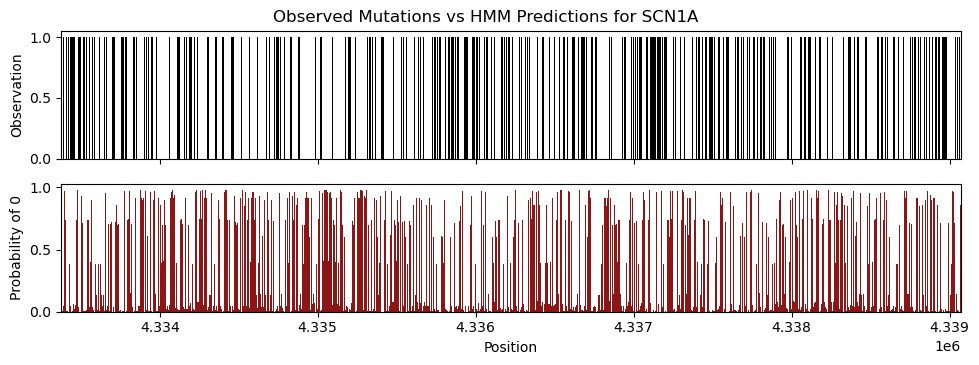

In [10]:
# Define the gene of interest
gene_name = "SCN1A"

# Extract the chromosome, start and end positions for the gene
gene_chrom = max(gene_df[(gene_df['gene_name'] == gene_name)]['chr'])
gene_start_pos = min(gene_df[(gene_df['gene_name'] == gene_name)]['start'])
gene_end_pos = max(gene_df[(gene_df['gene_name'] == gene_name)]['end'])

# Find the indices of the sequence corresponding to the gene
gene_start_idx = predictions_df[(predictions_df["chr"] == gene_chrom) & (predictions_df["pos"] >= gene_start_pos)]['pos'].idxmin()
gene_end_idx = predictions_df[(predictions_df["chr"] == gene_chrom) & (predictions_df["pos"] <= gene_end_pos)]['pos'].idxmax()
            
plot_subsequence(observations, predictions, gene_start_idx, gene_end_idx, gene_name=gene_name)

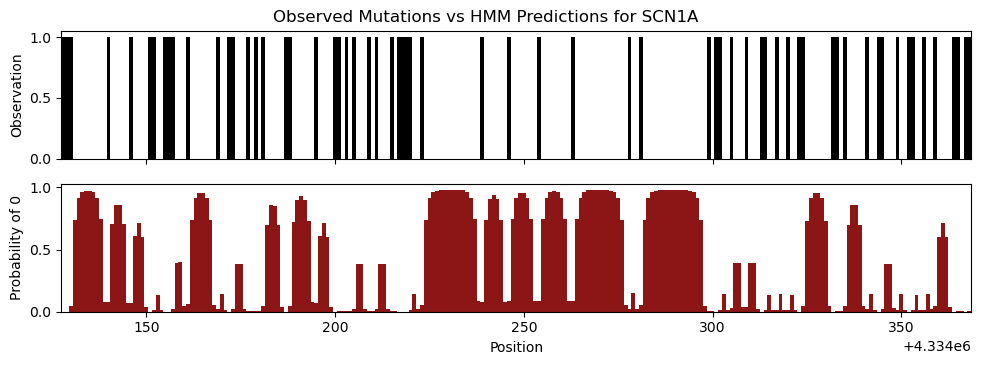

In [11]:
# Define the gene of interest
gene_name = "SCN1A"

# Extract the chromosome, start and end positions for the gene
gene_chrom = max(gene_df[(gene_df['gene_name'] == gene_name)]['chr'])
gene_start_pos = min(gene_df[(gene_df['gene_name'] == gene_name)]['start'])
gene_end_pos = max(gene_df[(gene_df['gene_name'] == gene_name)]['end'])

# Find the indices of the sequence corresponding to the gene
gene_start_idx = predictions_df[(predictions_df["chr"] == gene_chrom) & (predictions_df["pos"] >= gene_start_pos)]['pos'].idxmin()
gene_end_idx = predictions_df[(predictions_df["chr"] == gene_chrom) & (predictions_df["pos"] <= gene_end_pos)]['pos'].idxmax()
            
plot_subsequence(observations, predictions, gene_start_idx + 750, gene_end_idx - 4700, gene_name=gene_name, save_name="Figure 4: observed vs predicted mutations for SCN1A")

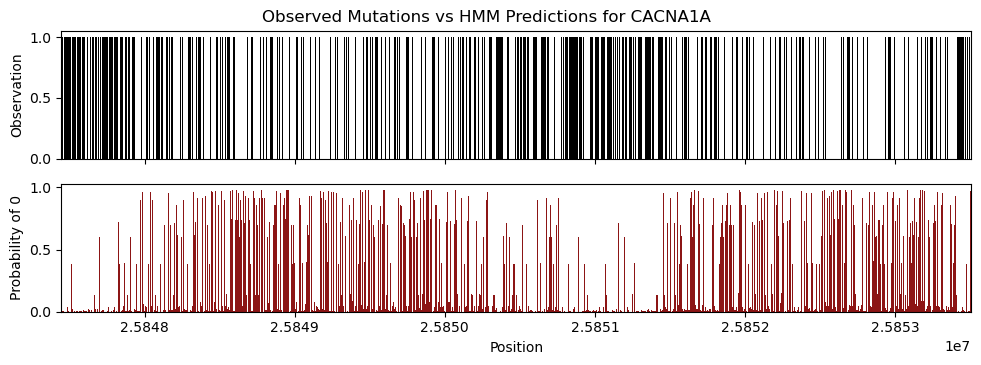

In [12]:
# Define the gene of interest
gene_name = "CACNA1A"

# Extract the chromosome, start and end positions for the gene
gene_chrom = max(gene_df[(gene_df['gene_name'] == gene_name)]['chr'])
gene_start_pos = min(gene_df[(gene_df['gene_name'] == gene_name)]['start'])
gene_end_pos = max(gene_df[(gene_df['gene_name'] == gene_name)]['end'])

# Find the indices of the sequence corresponding to the gene
gene_start_idx = predictions_df[(predictions_df["chr"] == gene_chrom) & (predictions_df["pos"] >= gene_start_pos)]['pos'].idxmin()
gene_end_idx = predictions_df[(predictions_df["chr"] == gene_chrom) & (predictions_df["pos"] <= gene_end_pos)]['pos'].idxmax()
            
plot_subsequence(observations, predictions, gene_start_idx, gene_end_idx, gene_name=gene_name)